## IM CSP Pipeline - All subjects - 2 classes

This notebook details a train and test a pipeline that uses two imaginary movement classes (left and right), by training a CSP filter followed by a gradient boosted classifier. This analysis was executed without normalization/PCA, with PCA, and with normalization for the full 64-channel dataset. Ultimately a comparison is made with the 8-channel headset (at the bottom of this file). If a rest class needs to be implemented in practice, this can be achieved by applying a threshold to the final probabilities of the model. 

## Import necessary libraries

In [1]:
! pip install -q --no-cache-dir mne lightning torchmetrics


In [2]:
import mne
from mne.io import concatenate_raws

import os
import re
import io
import cv2
import random
import string
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pickle

%matplotlib inline
plt.rcParams['axes.facecolor'] = 'lightgray'


## Load Physionet dataset

In [3]:
# EEG Motor Movement/Imagery Dataset:
# https://physionet.org/content/eegmmidb/1.0.0/

# This dataset consists of over 1500 one- and two-minute EEG recordings,
# sampled at 160 Hz, obtained from 109 volunteers.

# In summary, the experimental runs were:
# Run 1: Baseline, eyes open
# Run 2: Baseline, eyes closed
# Run 3: Task 1 (open and close left or right fist)
# Run 4: Task 2 (imagine opening and closing left or right fist)
# Run 5: Task 3 (open and close both fists or both feet)
# Run 6: Task 4 (imagine opening and closing both fists or both feet)
# Run 7: Task 1
# Run 8: Task 2
# Run 9: Task 3
# Run 10: Task 4
# Run 11: Task 1
# Run 12: Task 2
# Run 13: Task 3
# Run 14: Task 4

# Each annotation includes one of three codes of events (T0=1, T1=2, or T2=3):
# - T0 corresponds to rest
# - T1 corresponds to onset of motion (real or imagined) of
#     > the left fist (in runs 3, 4, 7, 8, 11, and 12)
#     > both fists (in runs 5, 6, 9, 10, 13, and 14)
# - T2 corresponds to onset of motion (real or imagined) of
#     > the right fist (in runs 3, 4, 7, 8, 11, and 12)
#     > both feet (in runs 5, 6, 9, 10, 13, and 14)


warnings.filterwarnings("ignore")
 
N_SUBJECTS = 109
BASELINE_EYE_OPEN = [1]
BASELINE_EYE_CLOSED = [2]
OPEN_CLOSE_LEFT_RIGHT_FIST = [3, 7, 11]
IMAGINE_OPEN_CLOSE_LEFT_RIGHT_FIST = [4, 8, 12]
OPEN_CLOSE_BOTH_FIST = [5, 9, 13]
IMAGINE_OPEN_CLOSE_BOTH_FIST = [6, 10, 14]
# change this to where the actual dataset is stored as a pkl file, if no local copy exist -> download
data_path = "../path/physionet_dataset.pkl"
 
# To speed up the process only load the data if it cannot be found locally
if os.path.isfile(data_path):
    with open(data_path, 'rb') as f:
        raw_obj_set = pickle.load(f)
else:
    physionet_files = [
    mne.datasets.eegbci.load_data(
        id,
        IMAGINE_OPEN_CLOSE_LEFT_RIGHT_FIST,
        "/root/mne_data",
    )
    for id in range(1, N_SUBJECTS+1)
    ]
    physionet_files = np.concatenate(physionet_files)
 
    # Read the downloaded raw data files where each file contains a run and place them in a list
    raws = [
    mne.io.read_raw_edf(
        physionet_file,
        preload=True,
        stim_channel='auto',
        verbose='WARNING',
    )
    for physionet_file in physionet_files
    ]
 
    # Split the raw data files per subject
    raws_set = list(zip(*[iter(raws)] * 3))
 
    # Combine all loaded runs into one edf object
    raw_obj_set = [concatenate_raws(list(raw)) for raw in raws_set]
   
    with open(data_path, 'wb') as f:
        pickle.dump(raw_obj_set, f)

channel_names = raw_obj_set[0].info['ch_names']

## General preprocessing

We see heavy powerline interference, which can be removed here through a notch filter at the frequency f = 60 Hz. However, [papers](https://iopscience.iop.org/article/10.1088/1741-2552/ac74e0) suggest that, for motor imagery, only information between 8-30 Hz is relevant. Because of this, we can just apply a bandpass filter to eliminate low frequency interference, high frequency noise and powerline intereference all in one go! To have some margin, in case the emotions team is interested in a broader frequency range than us, we choose a pass band of 0.5 Hz - 45 Hz for the general preprocessing filters. Later, during feature extraction, we can be more specific about the frequency band power features that we're interested in specifically for motor imagery anyway.

In [4]:
l_freq = 0.5
h_freq = 45

raw_obj_set = [raw_obj.load_data().filter(l_freq, h_freq) for raw_obj in raw_obj_set]

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth:

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth:

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth:

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth:

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth:

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth:

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


The same papers also mention that common average referencing is recommended for MI applications

In [5]:
raw_obj_set = [raw_obj.set_eeg_reference('average') for raw_obj in raw_obj_set]

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
E

## Events / annotations

Typically, during an experiment we mark the time when important events occur by integrating triggers into an EEG recording, which can be imported as 'Events'. An 'Event' will essentially give us information of when in time an external stimulus was presented, and of what this stimulus was, such as e.g. a visual signal to signal to the subject that he needs to close his left fist.

Once we have this information, we can convert our raw EEG signal to Epochs. This consists of extracting chunks of EEG data around a given window, marked by the time when each external event occured.

In [6]:
# Extract the events/annotations from the raw edf data object
events_set =  [mne.events_from_annotations(raw_obj, event_id='auto')[0][:] for raw_obj in raw_obj_set]
print(len(events_set))
print(len(events_set[0]))


Used Annotations descriptions: ['T0', 'T1', 'T2']
Used Annotations descriptions: ['T0', 'T1', 'T2']
Used Annotations descriptions: ['T0', 'T1', 'T2']
Used Annotations descriptions: ['T0', 'T1', 'T2']
Used Annotations descriptions: ['T0', 'T1', 'T2']
Used Annotations descriptions: ['T0', 'T1', 'T2']
Used Annotations descriptions: ['T0', 'T1', 'T2']
Used Annotations descriptions: ['T0', 'T1', 'T2']
Used Annotations descriptions: ['T0', 'T1', 'T2']
Used Annotations descriptions: ['T0', 'T1', 'T2']
Used Annotations descriptions: ['T0', 'T1', 'T2']
Used Annotations descriptions: ['T0', 'T1', 'T2']
Used Annotations descriptions: ['T0', 'T1', 'T2']
Used Annotations descriptions: ['T0', 'T1', 'T2']
Used Annotations descriptions: ['T0', 'T1', 'T2']
Used Annotations descriptions: ['T0', 'T1', 'T2']
Used Annotations descriptions: ['T0', 'T1', 'T2']
Used Annotations descriptions: ['T0', 'T1', 'T2']
Used Annotations descriptions: ['T0', 'T1', 'T2']
Used Annotations descriptions: ['T0', 'T1', 'T2']


MNE-Python represents events with integers stored in NumPy arrays of shape (n_events, 3). The first column contains the event onset (in samples). The last column contains the event code.

The second column reflects the fact that event arrays sometimes originate from analog voltage channels (“trigger channels” or “stim channels”). In most cases, the second column is all zeros and can be ignored.

In [7]:
print(np.shape(events_set[0])) # This means that we have - on average - 30 annotations per run, since 50 x 3 x 30 = 4500

print("Number of events with label 1: ", str(np.count_nonzero(events_set[0][:,2] ==  1)))
print("Number of events with label 2: ", str(np.count_nonzero(events_set[0][:,2] ==  2)))
print("Number of events with label 3: ", str(np.count_nonzero(events_set[0][:,2] ==  3)))


(90, 3)
Number of events with label 1:  45
Number of events with label 2:  23
Number of events with label 3:  22


To be able to define epochs in our EEG data, a time interval of interest should be selected.

tmin and tmax represent the beginning and the end of the selected time interval (in seconds). This selection may differ, depending on the experiment. If the reponse to the given stimuli is expected to happen quickly, then a narrow time interval may be needed and vice versa.

Here, trials are cut in the interval [1–4s] or [0.5–2.5s] after the onset of the cue.

Note: if we wanted to also extract data from before the cue, then tmin should be negative.

In [8]:
# tmin, tmax = 1, 4
tmin, tmax = 0.5, 2.5

# To exclude any bad eeg data automatically from the epochs if there is any
eeg_channel_inds_set = [ mne.pick_types(
    raw_obj.info,
    meg=False,
    eeg=True,
    stim=False,
    eog=False,
    exclude='bads',
) for raw_obj in raw_obj_set
]

epoched_set = [mne.Epochs(
    raw_obj,
    events,
    dict(left=2, right=3), # Class labels we're interested in
    tmin=tmin,
    tmax=tmax,
    proj=False,
    picks=eeg_channel_inds,
    baseline=None,
    preload=True
) for raw_obj,events,eeg_channel_inds in zip(raw_obj_set, events_set, eeg_channel_inds_set)
]

Not setting metadata
45 matching events found
No baseline correction applied
Using data from preloaded Raw for 45 events and 321 original time points ...
0 bad epochs dropped
Not setting metadata
45 matching events found
No baseline correction applied
Using data from preloaded Raw for 45 events and 321 original time points ...
0 bad epochs dropped
Not setting metadata
45 matching events found
No baseline correction applied
Using data from preloaded Raw for 45 events and 321 original time points ...
0 bad epochs dropped
Not setting metadata
45 matching events found
No baseline correction applied
Using data from preloaded Raw for 45 events and 321 original time points ...
0 bad epochs dropped
Not setting metadata
45 matching events found
No baseline correction applied
Using data from preloaded Raw for 45 events and 321 original time points ...
0 bad epochs dropped
Not setting metadata
45 matching events found
No baseline correction applied
Using data from preloaded Raw for 45 events and 

In [9]:
# If your EEG data is in a matrix with dimensions [channels x time] where time
# is the complete continuous EEG signal, then after the epoching procedure you
# should have a matrix with dimensions [epochs x channels x time] where time is
# the time length of each epoch, and epochs is the number of segments you
# extracted from the continuous EEG signal.
print(np.shape(epoched_set[0]))

(45, 64, 321)


In [10]:
# Convert data from Volt to milliVolt
X_set = [(epoched.get_data() * 1e3).astype(np.float32) for epoched in epoched_set]
X_ML_set = X_set.copy()
X_DL_set = X_set.copy()

# Convert class labels to 0 and 1 instead of 2 and 3
y_set = [(epoched.events[:, 2] - 2).astype(np.int64) for epoched in epoched_set]
CLASSES = ["left", "right"]
cl1 = CLASSES[0]
cl2 = CLASSES[1]


In [11]:
# Might be easier for feature extraction to put the epochs as the last dimension
X_ML_set = [np.transpose(X_ML, (1, 2, 0)) for X_ML in X_ML_set]

In [12]:
# Determine indices where y = 0 (left fist) and where y = 1 (right fist)
mask_0_set = [y==0 for y in y_set]
mask_1_set = [y==1 for y in y_set]

## Preprocessing specifically for classical machine learning in motor imagery applications

In [13]:
# We're going to define a function which calculates the PSD for each separate
# epoch, such that we can later inspect potential differences in the PSD's of
# different classes. However, because now we have numpy data, we can't use
# plot_psd() anymore.

from matplotlib import mlab

def psd(trials):
    '''
    Calculates for each trial the Power Spectral Density (PSD).

    Parameters
    ----------
    trials : 3d-array (channels x samples x trials)
        The EEG signal

    Returns
    -------
    trial_PSD : 3d-array (channels x PSD x trials)
        the PSD for each trial.
    freqs : list of floats
        Yhe frequencies for which the PSD was computed (useful for plotting later)
    '''
    nchannels = trials.shape[0]
    ntrials = trials.shape[2]
    trials_PSD = np.zeros((nchannels, 129, ntrials))

    # Iterate over trials and channels
    for trial in range(ntrials):
        for ch in range(nchannels):
            # Calculate the PSD according to Welch's method
            # For numpy data, we can use the following: https://het.as.utexas.edu/HET/Software/Matplotlib/api/mlab_api.html#matplotlib.mlab.psd
            (PSD, freqs) = mlab.psd(trials[ch,:,trial], Fs=160)
            trials_PSD[ch, :, trial] = PSD.ravel()

    return trials_PSD, freqs


In [14]:
# Call the above function on the epochs of the two different classes
_, freqs = psd(X_ML_set[0][:,:,mask_0_set[0]])
psds_left_set = [psd(X_ML_set[i][:,:,mask_0_set[i]])[0] for i in range(len(X_ML_set))]
psds_right_set = [psd(X_ML_set[i][:,:,mask_1_set[i]])[0] for i in range(len(X_ML_set))]
trials_PSD = {cl1: psds_left_set[0], cl2: psds_right_set[0]}


In [15]:
# Define a function which can now plot the class-average PSD's at different
# electrode locations

def plot_psd(trials_PSD, freqs, chan_ind, chan_lab=None, limitx=True, maxy=1.5 * 10**-5):
    '''
    Plots PSD data calculated with psd().

    Parameters
    ----------
    trials_PSD : 3d-array
        The PSD data, as returned by psd()
    freqs : list of floats
        The frequencies for which the PSD is defined, as returned by psd()
    chan_ind : list of integers
        The indices of the channels to plot
    chan_lab : list of strings
        (optional) List of names for each channel
    maxy : float
        (optional) Limit the y-axis to this value
    '''
    plt.figure(figsize=(12,5))

    nchans = len(chan_ind)

    # Maximum of 3 plots per row
    nrows = int(np.ceil(nchans / 3))
    ncols = min(3, nchans)

    # Enumerate over the channels
    for i,ch in enumerate(chan_ind):
        # Figure out which subplot to draw to
        plt.subplot(nrows,ncols,i+1)

        # Plot the PSD for each class
        for cl in trials_PSD.keys():
            plt.plot(freqs, np.mean(trials_PSD[cl][ch,:,:], axis=1), label=cl)

        # All plot decoration below...
        if limitx:
          plt.xlim(1,30)

        if maxy != None:
            plt.ylim(0,maxy)

        plt.grid()

        plt.xlabel('Frequency (Hz)')

        if chan_lab == None:
            plt.title('Channel %d' % (ch+1))
        else:
            plt.title(chan_lab[i])

        plt.legend()

    plt.tight_layout()


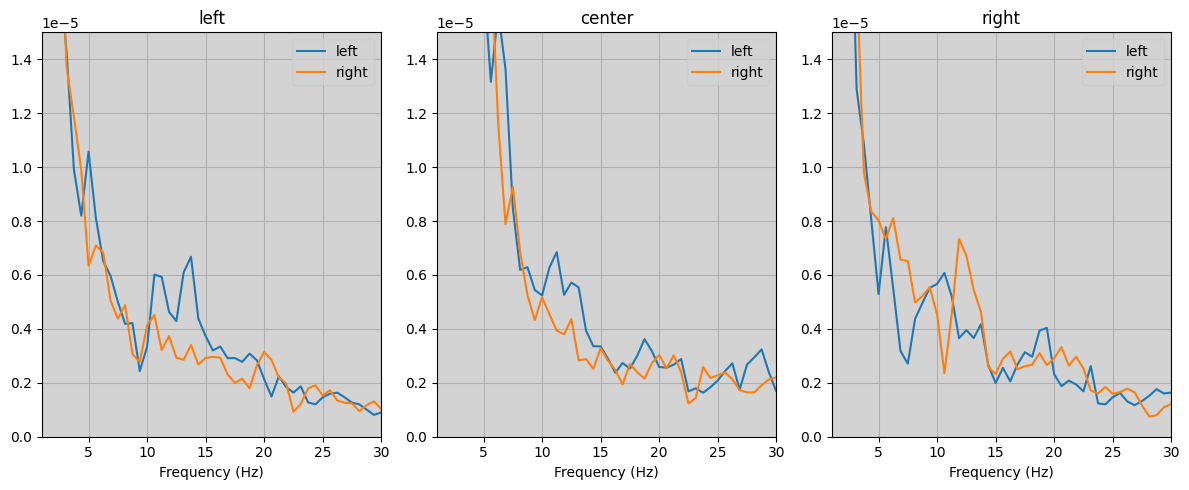

In [16]:
plot_psd(
    trials_PSD,
    freqs,
    [channel_names.index(ch) for ch in ['C3..', 'Cz..', 'C4..']],
    chan_lab=['left', 'center', 'right'],
    # limitx=False,
    # maxy=None
)

We can see that, indeed, the frequency range 8-30 Hz is the most interesting one. This consists of the Mu band (8-12 Hz) and the Beta band (12-30 Hz). Often, a combination of the Mu and the Beta frequency bands is more important in MI than each of those separately, so for now we will also start by only focussing on the 8-15 Hz frequency range specifically.

In [17]:
# The script below designs a band pass filter using scipy.signal.irrfilter that
# will strip away frequencies outside the 8-15Hz window. The filter is applied
# to all trials

import scipy.signal

def bandpass(trials, lo, hi, sample_rate):
    '''
    Designs and applies a bandpass filter to the signal.

    Parameters
    ----------
    trials : 3d-array (channels x samples x trials)
        The EEGsignal
    lo : float
        Lower frequency bound (in Hz)
    hi : float
        Upper frequency bound (in Hz)
    sample_rate : float
        Sample rate of the signal (in Hz)

    Returns
    -------
    trials_filt : 3d-array (channels x samples x trials)
        The bandpassed signal
    '''

    # The iirfilter() function requires a filter order: higher numbers mean a sharper frequency cutoff,
    # but the resulting signal might be shifted in time, while lower numbers mean a softer frequency cutoff,
    # but the resulting signal is less distorted in time.
    a, b = scipy.signal.iirfilter(6, [lo/(sample_rate/2.0), hi/(sample_rate/2.0)])

    # Applying the filter to each trial
    nchannels = trials.shape[0]
    nsamples = trials.shape[1]
    ntrials = trials.shape[2]
    trials_filt = np.zeros((nchannels, nsamples, ntrials))
    for i in range(ntrials):
        trials_filt[:,:,i] = scipy.signal.filtfilt(a, b, trials[:,:,i], axis=1)

    return trials_filt


In [ ]:
X_ML_set = [bandpass(X_ML, 8, 15, 160) for X_ML in X_ML_set]

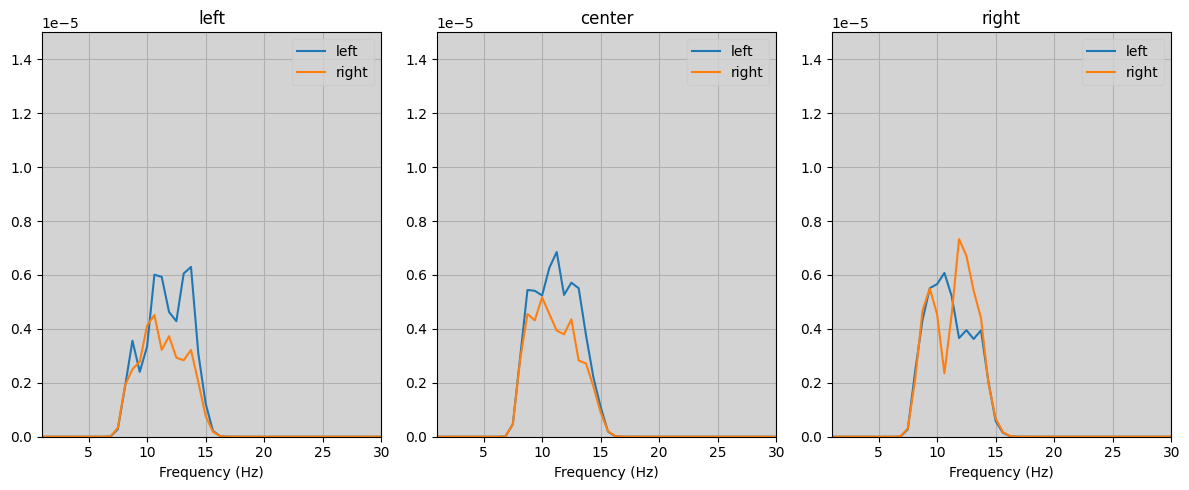

In [ ]:
_, freqs = psd(X_ML_set[0][:,:,mask_0_set[0]])
psds_left_set = [psd(X_ML_set[i][:,:,mask_0_set[i]])[0] for i in range(len(X_ML_set))]
psds_right_set = [psd(X_ML_set[i][:,:,mask_1_set[i]])[0] for i in range(len(X_ML_set))]
trials_PSD = {cl1: psds_left_set[0], cl2: psds_right_set[0]}

plot_psd(
    trials_PSD,
    freqs,
    [channel_names.index(ch) for ch in ['C3..', 'Cz..', 'C4..']],
    chan_lab=['left', 'center', 'right'],
    # limitx=False,
    # maxy=None
)


## Classical Machine Learning model

As a feature for the classifier, we might want to use e.g. (the logarithm of) the variance of each channel. The function below calculates this:

In [18]:
def logvar(trials):
    '''
    Calculate the log-var of each channel.

    Parameters
    ----------
    trials : 3d-array (channels x samples x trials)
        The EEG signal.

    Returns
    -------
    logvar - 2d-array (channels x trials)
        For each channel the logvar of the signal
    '''
    return np.log(np.var(trials, axis=1))


In [ ]:
trials_logvar1_set = [logvar(X_ML[:,:,mask_0]) for X_ML, mask_0 in zip(X_ML_set,mask_0_set)]
trials_logvar2_set = [logvar(X_ML[:,:,mask_1]) for X_ML, mask_1 in zip(X_ML_set,mask_1_set)]
trials_logvar = {cl1: trials_logvar1_set[0],
                 cl2: trials_logvar2_set[0]}

In [19]:
# Below is a function to visualize the average log-var of each channel, whilst
# comparing differences between the channel log-vars of the 2 classes

def plot_logvar(trials):
    '''
    Plots the log-var of each channel/component.
    arguments:
        trials - Dictionary containing the trials (log-vars x trials) for 2 classes.
    '''
    plt.figure(figsize=(12,5))

    nchannels = trials[cl1].shape[0]

    x0 = np.arange(nchannels)
    x1 = np.arange(nchannels) + 0.4

    y0 = np.mean(trials[cl1], axis=1)
    y1 = np.mean(trials[cl2], axis=1)

    plt.bar(x0, y0, width=0.5, color='b')
    plt.bar(x1, y1, width=0.4, color='r')

    plt.xlim(-0.5, nchannels+0.5)

    plt.gca().yaxis.grid(True)
    plt.title('log-var of each channel/component')
    plt.xlabel('channels/components')
    plt.ylabel('log-var')
    plt.legend(CLASSES)


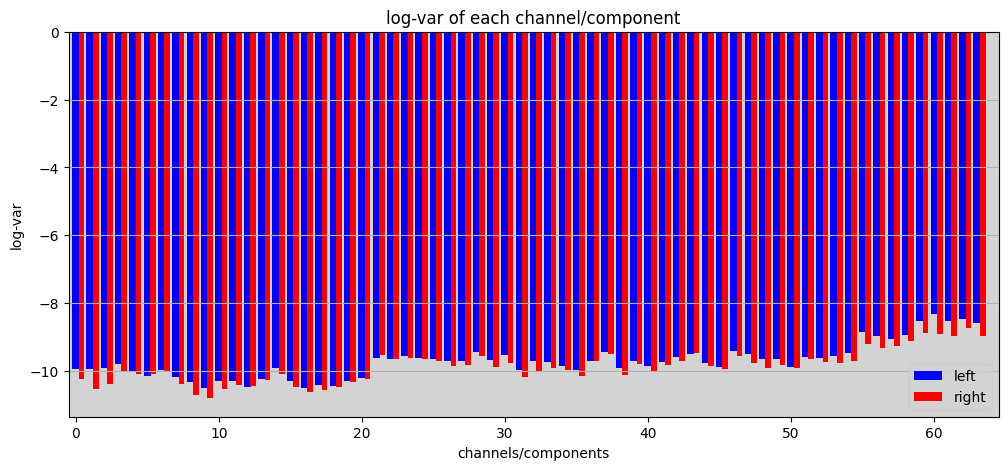

In [ ]:
plot_logvar(trials_logvar)

However, we see that most channels show only a small difference in the log-variance of the signal between the two classes.

The [CSP algorithm](https://en.wikipedia.org/wiki/Common_spatial_pattern), however, can calculate mixtures of channels with mixture coefficients that are designed to maximize the difference in variance between our two classes - it maximizes their variance ratio - in their output. These mixures are thus essentially the outputs of specially designed spatial filters.

More explanation is found in some of my old course notes:
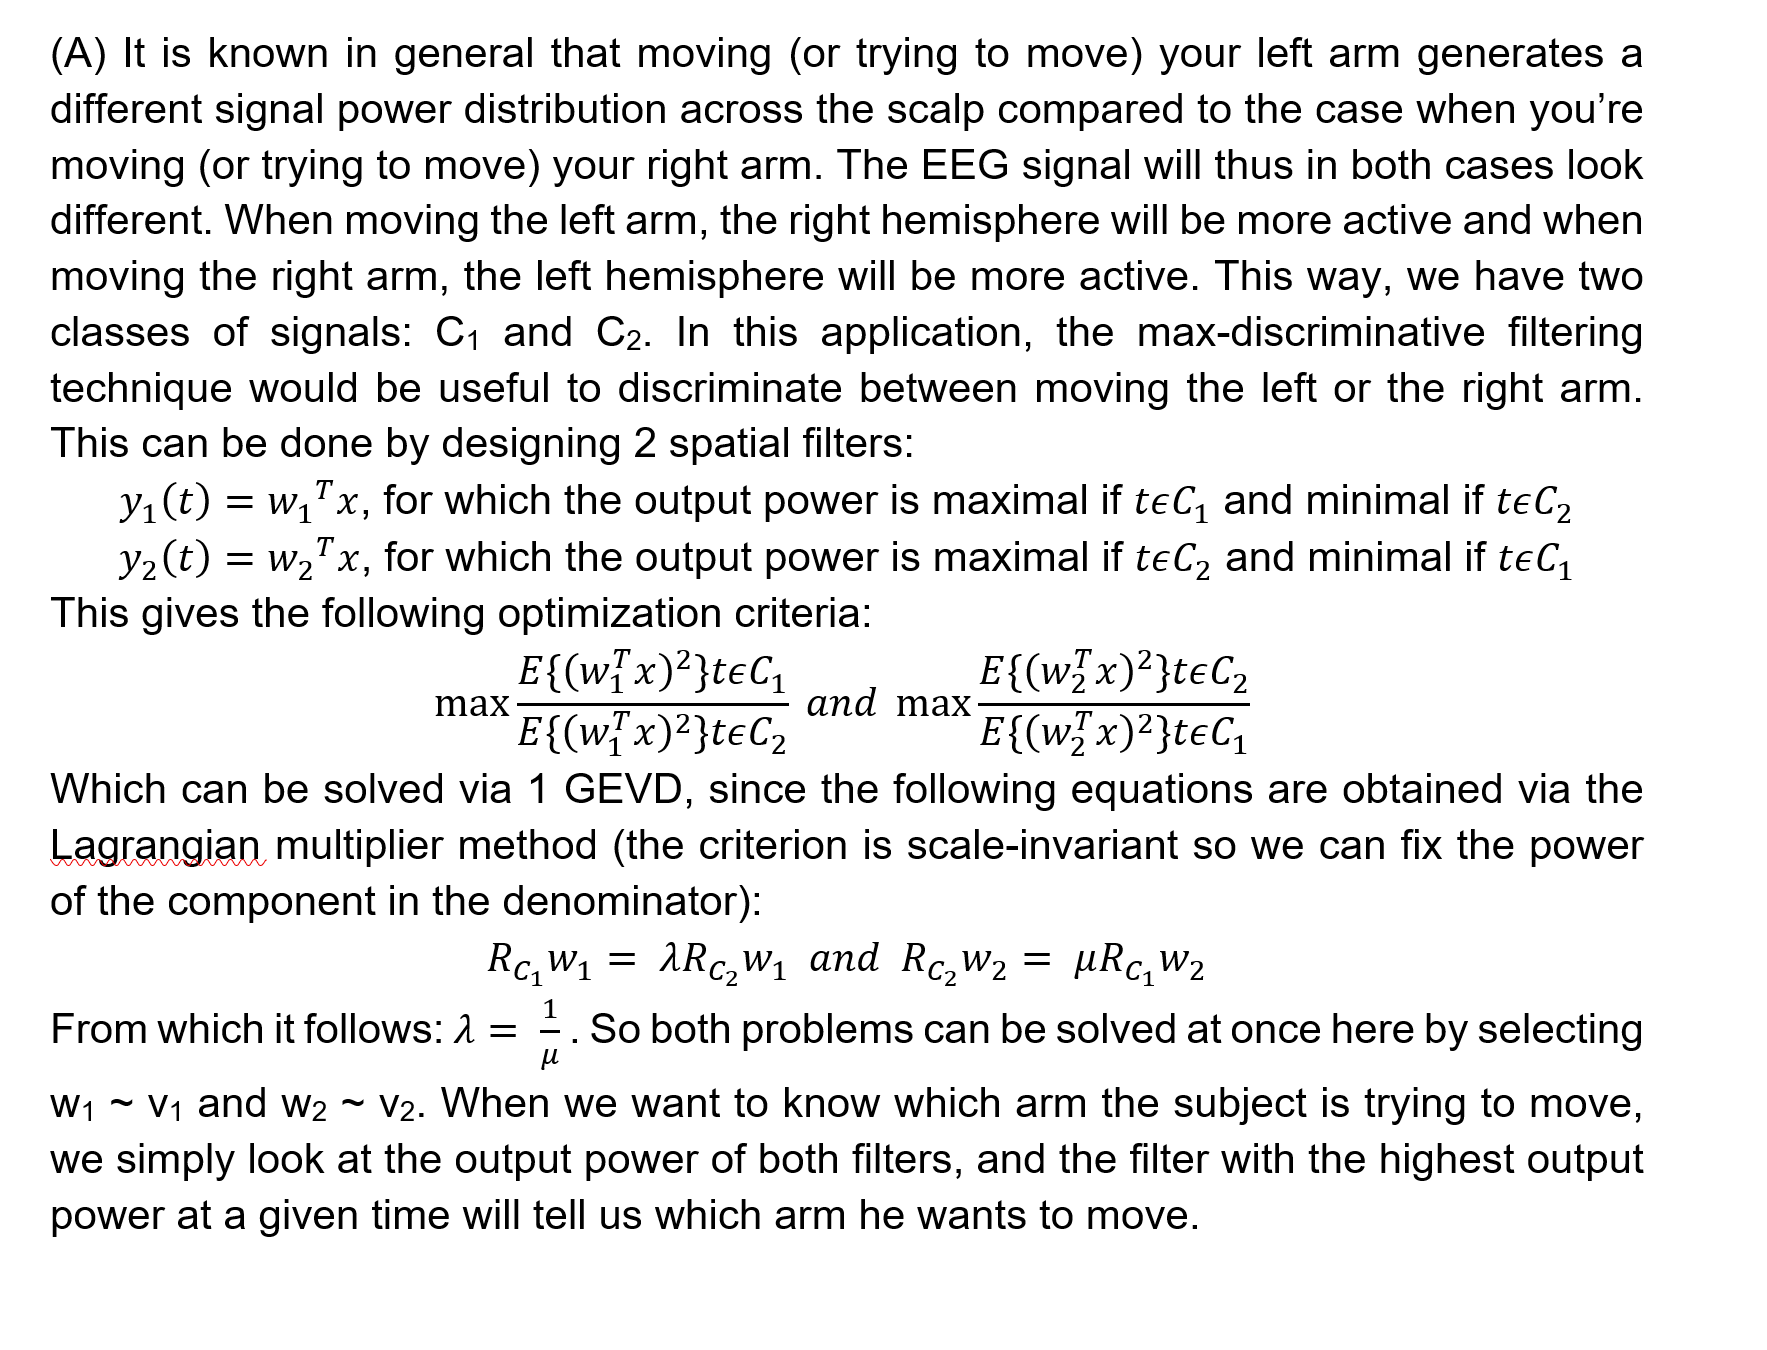

The information displayed in the above screenshot means that for our one GEVD problem formulation based on the joint diagonalization of the covariance matrices R1 and R2:
- selecting the eigenvector associated with a high eigenvalue as filter coefficients means that the output channel of that filter will yield a high variance for input signals in class 1 and a low variance for signals in class 2
- selecting the eigenvector associated with a low eigenvalue as filter coefficients means that the output channel of that filter will yield a high variance for input signals in class 2 and a low variance for signals in class 1

In our application, however, we're not going to retain any specific components of the GEVD yet. For now, we're just going to use all components, i.e. we're just gonna generate 64 different spatial filters based on the 64 different eigenvectors that can be generated from our data.

In [20]:
from numpy import linalg

def cov(trials):
    ''' Calculate the covariance for each trial and return their average '''
    nsamples = trials.shape[1]
    ntrials = trials.shape[2]
    covs = [ trials[:,:,i].dot(trials[:,:,i].T) / nsamples for i in range(ntrials) ]
    return np.mean(covs, axis=0)

def whitening(sigma):
    ''' Calculate a whitening matrix for covariance matrix sigma. '''
    U, l, _ = linalg.svd(sigma)
    return U.dot( np.diag(l ** -0.5) )

def csp(trials_l, trials_r):
    '''
    Calculate the CSP transformation matrix W.
    arguments:
        trials_r - Array (channels x samples x trials) containing right hand movement trials
        trials_l - Array (channels x samples x trials) containing left hand movement trials
    returns:
        Mixing matrix W
    '''
    cov_r = cov(trials_r)
    cov_l = cov(trials_l)
    P = whitening(cov_r + cov_l)
    B, _, _ = linalg.svd( P.T.dot(cov_l).dot(P) )
    W = P.dot(B)
    return W

def apply_mix(W, trials):
    ''' Apply a mixing matrix to each trial (basically multiply W with the EEG signal matrix)'''
    nchannels = trials.shape[0]
    nsamples = trials.shape[1]
    ntrials = trials.shape[2]
    trials_csp = np.zeros((nchannels, nsamples, ntrials))
    for i in range(ntrials):
        trials_csp[:,:,i] = W.T.dot(trials[:,:,i])
    return trials_csp

In [ ]:
# Estimation of W needs to happen on training data with annotations
# Otherwise, it's not possible
W_set = [csp(X_ML_set[i][:,:,mask_0_set[i]], X_ML_set[i][:,:,mask_1_set[i]]) for i in range(len(X_ML_set))]
X_ML_CSP_set = [apply_mix(W, X_ML) for W, X_ML in zip(W_set,X_ML_set)]

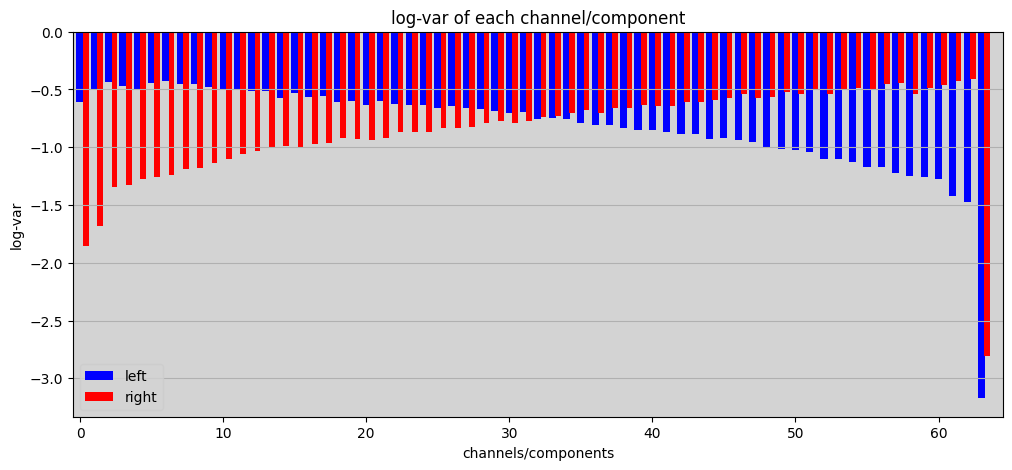

In [ ]:
# Now, we visualize the average log-var of each CSP component output, repeating
# the comparison of differences between the channel log-vars of the 2 classes
trials_logvar1_set = [logvar(X_ML[:,:,mask_0]) for X_ML, mask_0 in zip(X_ML_CSP_set,mask_0_set)]
trials_logvar2_set = [logvar(X_ML[:,:,mask_1]) for X_ML, mask_1 in zip(X_ML_CSP_set,mask_1_set)]
trials_logvar = {cl1: trials_logvar1_set[0],
                 cl2: trials_logvar2_set[0]}
plot_logvar(trials_logvar)

Instead of 64 channels, we now have 64 mixtures of channels, called components. They are, as previously explained, the result of 64 spatial filters being applied to the data. We can now see that the difference in the log-var of the 2 classes has indeed been increased by the CSP algorithm!

In [ ]:
# We can now also compare the class-specific mean PSD's at the output of the
# CSP component channels
_, freqs = psd(X_ML_CSP_set[0][:,:,mask_0_set[0]])
psd_left_set = [psd(X_ML_CSP_set[i][:,:,mask_0_set[i]])[0] for i in range(len(X_ML_CSP_set))]
psd_right_set = [psd(X_ML_CSP_set[i][:,:,mask_1_set[i]])[0] for i in range(len(X_ML_CSP_set))]
trials_PSD = {cl1: psd_left_set[0], cl2: psd_right_set[0]}

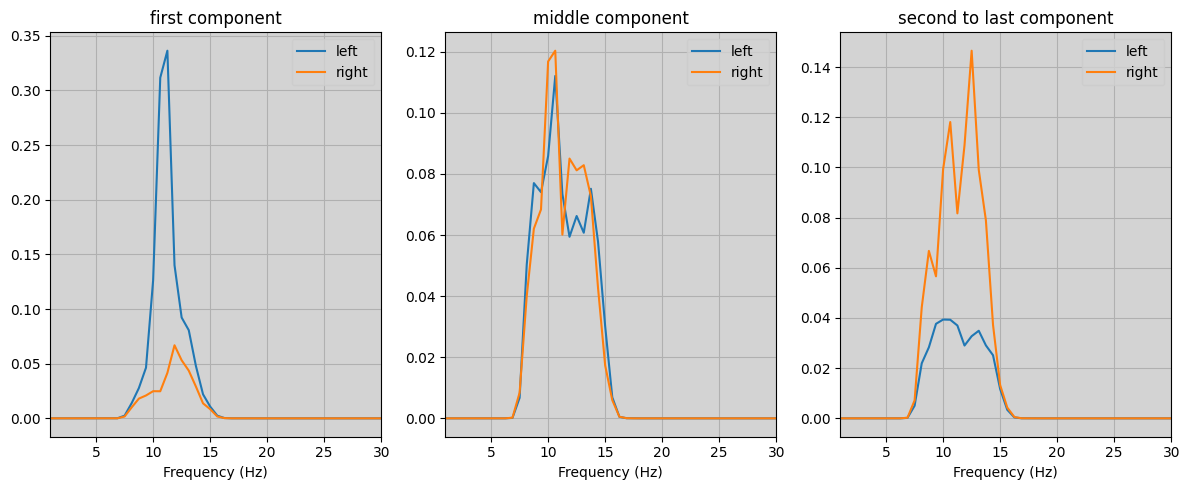

In [ ]:
plot_psd(trials_PSD, freqs, [0,31,-2], chan_lab=['first component', 'middle component', 'second to last component'], maxy=None)

In [ ]:
# First, we calculate the PSD of each CSP channel of each trial in X_ML_CSP
_, freqs = psd(X_ML_CSP_set[0])
X_ML_CSP_PSD_set = [psd(X_ML_CSP)[0] for X_ML_CSP in X_ML_CSP_set]

In [21]:
# Write a function which can derive the desired features and which places
# them in a dataframe which can then be used by our machine learning classifier

from scipy.stats import kurtosis, skew
import pandas as pd

def extract_features(trials_PSDs, trials_time, CSP_components):

    component_1 = CSP_components[0]
    component_2 = CSP_components[1]

    df = pd.DataFrame(columns=['psd_power_1', 'psd_max_1', 'psd_kurtosis_1', 'psd_skew_1',
                               'psd_power_2', 'psd_max_2', 'psd_kurtosis_2', 'psd_skew_2',
                               'time_logvar_1', 'time_rms_1', 'time_kurtosis_1', 'time_skew_1',
                               'time_logvar_2', 'time_rms_2', 'time_kurtosis_2', 'time_skew_2'])
    for trial in range(trials_PSDs.shape[2]):
        psd_component_1 = trials_PSDs[component_1,:,trial][(freqs>=8) & (freqs<=15)]
        psd_component_2 = trials_PSDs[component_2,:,trial][(freqs>=8) & (freqs<=15)]

        power_1 = np.trapz(psd_component_1)
        power_2 = np.trapz(psd_component_2)
        max_1 = max(psd_component_1)
        max_2 = max(psd_component_2)
        kurtosis_1 = kurtosis(psd_component_1)
        kurtosis_2 = kurtosis(psd_component_2)
        skew_1 = skew(psd_component_1)
        skew_2 = skew(psd_component_2)

        time_component_1 = trials_time[component_1,:,trial]
        time_component_2 = trials_time[component_2,:,trial]

        logvar_1 = np.log(np.var(time_component_1))
        logvar_2 = np.log(np.var(time_component_2))
        rms_1 = np.sqrt(np.mean(np.square(time_component_1)))
        rms_2 = np.sqrt(np.mean(np.square(time_component_2)))
        time_kurtosis_1 = kurtosis(time_component_1)
        time_kurtosis_2 = kurtosis(time_component_2)
        time_skew_1 = skew(time_component_1)
        time_skew_2 = skew(time_component_2)

        row = [power_1, max_1, kurtosis_1, skew_1,
               power_2, max_2, kurtosis_2, skew_2,
               logvar_1, rms_1, time_kurtosis_1, time_skew_1,
               logvar_2, rms_2, time_kurtosis_2, time_skew_2]

        df.loc[len(df)] = row

    return df

In [ ]:
# Now that all CSP calculations have been made subject specific, the features and labels can be merged
ML_features_set = [extract_features(X_ML_CSP_PSD, X_ML_CSP, [0, -2]) for X_ML_CSP_PSD, X_ML_CSP in zip(X_ML_CSP_PSD_set, X_ML_CSP_set)]
ML_features = pd.concat(ML_features_set)
mask_0 = np.concatenate(mask_0_set)
mask_1 = np.concatenate(mask_1_set)
y = np.concatenate(y_set)

In [ ]:
ML_features

,psd_power_1,psd_max_1,psd_kurtosis_1,psd_skew_1,psd_power_2,psd_max_2,psd_kurtosis_2,psd_skew_2,time_logvar_1,time_rms_1,time_kurtosis_1,time_skew_1,time_logvar_2,time_rms_2,time_kurtosis_2,time_skew_2
0,0.453906,0.114116,-0.673527,0.848726,0.663504,0.153502,-0.659991,0.874404,-1.693582,0.428809,-0.148929,0.025192,-0.594912,0.742733,-0.250185,-0.018368
1,1.053037,0.421760,1.815512,1.727132,0.477722,0.121639,-0.093928,0.872688,0.664654,1.394443,-0.006765,-0.029321,-1.438542,0.487255,0.656933,-0.010262
2,0.857134,0.410939,4.688250,2.373933,0.359258,0.084690,-1.266507,0.646813,-0.665221,0.717060,-0.690915,-0.015072,-1.550788,0.460535,-0.762508,-0.029312
3,0.169770,0.029822,-1.289639,0.325970,1.213245,0.311567,-0.197597,0.998567,-1.951432,0.376943,-0.636079,-0.036383,-0.146217,0.929674,0.151776,0.115524
4,0.262158,0.073866,-0.100255,1.133591,0.334896,0.060233,-1.360659,0.094052,-2.150698,0.341195,-0.068287,0.010763,-0.996252,0.607840,-0.358754,-0.021429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40,0.624222,0.157852,-0.985588,0.740133,0.449040,0.188371,2.360055,1.829823,-0.800285,0.670228,-0.728468,0.002405,-1.160661,0.559797,-0.273367,0.058870
41,0.319376,0.109838,2.565784,1.813799,0.907469,0.274719,-0.028388,1.091254,-1.522731,0.467087,0.492775,-0.002015,-0.584248,0.746688,-0.724881,0.003120
42,0.788071,0.187738,-0.076569,1.092717,0.479759,0.135272,0.514513,1.130747,-0.730205,0.694131,-0.542935,0.004027,-1.395087,0.497827,0.663608,-0.020999
43,0.166290,0.032901,-0.431494,0.488570,0.632058,0.163645,-0.227003,1.055368,-1.699146,0.427600,-0.156002,0.022813,-0.989107,0.609913,-0.021955,-0.025851


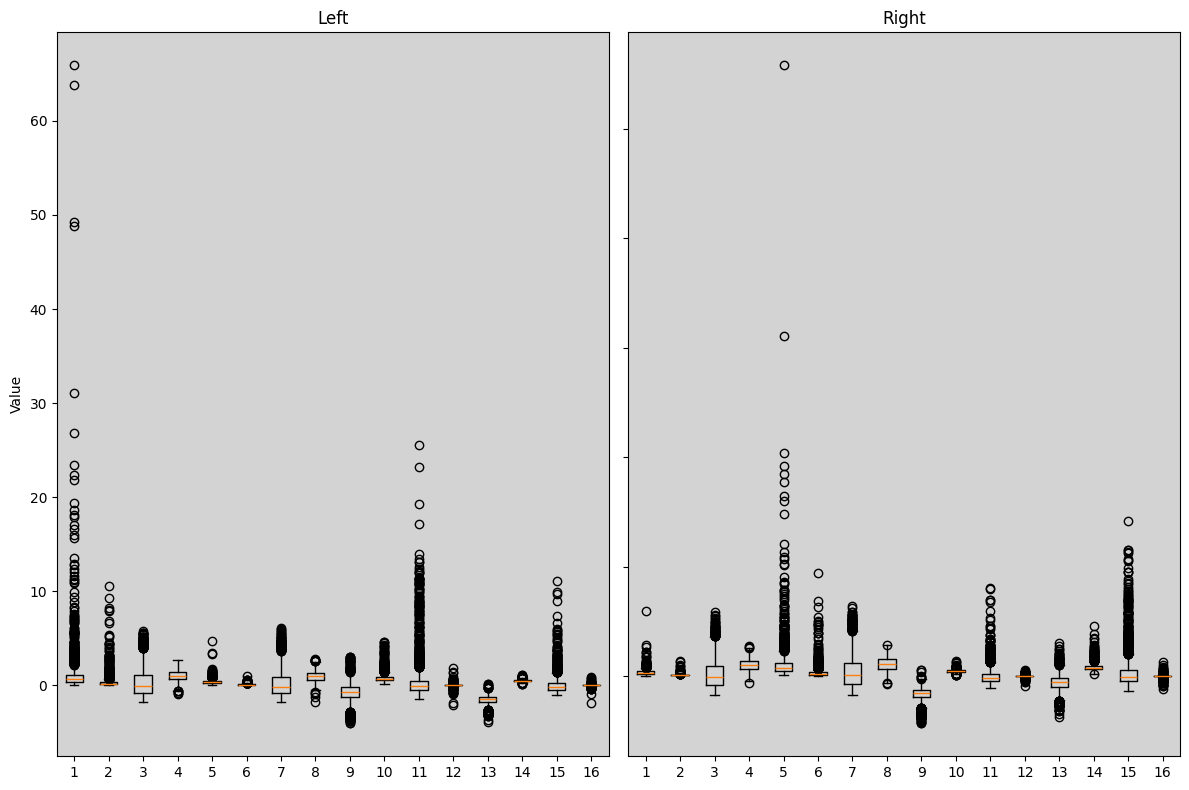

In [ ]:
# Create subplots in a 1x2 grid
fig, axs = plt.subplots(1, 2, figsize=(12, 8))

# Compare feature boxplots from class 1 and class 2
axs[0].boxplot(ML_features.loc[mask_0])
axs[0].set_title("Left")
axs[1].boxplot(ML_features.loc[mask_1])
axs[1].set_title("Right")

# Set y-axis label
for ax in axs.flat:
    ax.set(ylabel="Value")

# Add labels to the x-axis
for ax in axs.flat:
    ax.label_outer()

# Adjust layout for better appearance
plt.tight_layout()

# Show the boxplots
plt.show()

Now, we can really look towards training a machine learning classifier. But first, we will need to make a train-test split!

In [ ]:
from sklearn.model_selection import train_test_split

x = ML_features.copy()
y = y.copy()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    shuffle=False,
                                                    random_state=87)

In [ ]:
print('Train set:')
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

print('Test set:')
unique, counts = np.unique(y_test, return_counts=True)
print(np.asarray((unique, counts)).T)


Train set:
[[   0 1985]
 [   1 1949]]
Test set:
[[  0 495]
 [  1 489]]


The dataset is also pretty balanced, so no oversampling is needed here.

Now, we can look towards actually training an algorithm!

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import time

# Reproducibility
RANDOM_SEED = 87

In [23]:
def tune_train_test_pipeline(base_clf, clf_params, x_train, y_train, x_test, y_test):

    # Record the start time
    start_time = time.time()

    # Split the training data into 5 folds using cross-validation to tune hyperparameters
    cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

    # Use GridSearchCV to train the model for a given set of hyperparameter values
    # in clf_params and calculate the accuracy of each model to select the best
    # set of hyperparameters whilst using the cross-validation technique to
    # partition the validation data from the training data.
    tuned_clf = GridSearchCV(estimator=base_clf, param_grid=clf_params,
                              scoring=['accuracy'], refit='accuracy', cv=cv_splitter)

    # Fit the model on the training data
    tuned_clf.fit(x_train, y_train)

    # Best hyperparameters and cross-validation score
    print('Best hyperparameters: {}'.format(tuned_clf.best_params_))
    print("Best cross-validation score: {:.2f}".format(tuned_clf.best_score_))

    # Let the model predict on the train data and calculate the accuracy score
    prediction_train = tuned_clf.predict(x_train)
    accuracy_train = accuracy_score(y_train, prediction_train)

    # Let the model predict on the test data and calculate the accuracy score
    prediction_test = tuned_clf.predict(x_test)
    accuracy_test = accuracy_score(y_test, prediction_test)

    # Display model classification report for training data and test data
    print('Training Set: Classification report')
    print(classification_report(y_train, prediction_train))
    print('\nTest Set: Classification report')
    print(classification_report(y_test, prediction_test))

    # Define the class labels if you have them (optional)
    class_labels = ["left", "right"]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    cmap = plt.get_cmap('Blues')

    # Calculate and display the model's confusion matrix for the training data
    cm_train = confusion_matrix(y_train, prediction_train)
    display = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=class_labels)
    display.plot(ax=ax1, cmap=cmap)
    ax1.set_title('[Training Data] \nConfusion Matrix: tuned model')
    # Calculate and display the model's confusion matrix for the test data
    cm_test = confusion_matrix(y_test, prediction_test)
    display = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=class_labels)
    display.plot(ax=ax2, cmap=cmap)
    ax2.set_title('[Test Set] \nConfusion Matrix: tuned model')

    plt.tight_layout()
    plt.show()

    end_time = time.time()  # Record the end time
    training_time = end_time - start_time  # Calculate the training time
    training_time = training_time / 60 # Convert training time to minutes
    print("Processing time: {:.2f} minutes".format(training_time))

    return tuned_clf, [accuracy_train,accuracy_test], cm_train, cm_test, training_time

Best hyperparameters: {'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 2, 'n_estimators': 50}
Best cross-validation score: 0.88
Training Set: Classification report
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      1985
           1       0.89      0.87      0.88      1949

    accuracy                           0.88      3934
   macro avg       0.88      0.88      0.88      3934
weighted avg       0.88      0.88      0.88      3934


Test Set: Classification report
              precision    recall  f1-score   support

           0       0.87      0.80      0.84       495
           1       0.82      0.88      0.85       489

    accuracy                           0.84       984
   macro avg       0.84      0.84      0.84       984
weighted avg       0.84      0.84      0.84       984



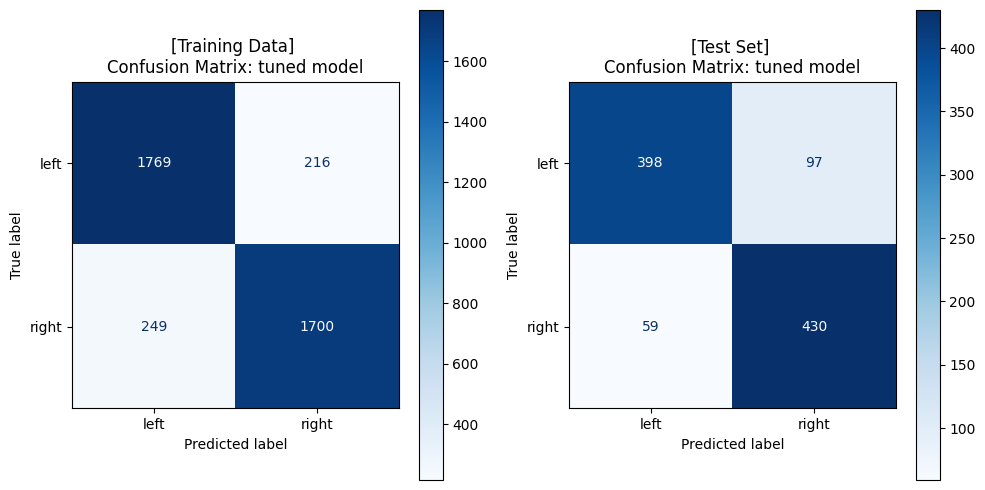

Processing time: 0.06 minutes


In [38]:
base_clf = GBC()
clf_params = {
    'loss': ['log_loss', 'exponential'],  # The loss function to be optimized.
    'n_estimators': [25, 50, 100, 150, 200],  # The number of boosting stages (trees)
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5],  # The step size shrinkage used to prevent overfitting
    'max_depth': [2, 3, 4, 5]}  # Maximum depth of the individual trees
tuned_gb, accuracy_gb, cm_train_gb, cm_test_gb, processing_gb_time = tune_train_test_pipeline(base_clf, clf_params, x_train, y_train, x_test, y_test)

Try PCA on the features and see if we can get better results

In [39]:
# Normalize the feature matrix
df_features_normalized = (x - x.mean()) / x.std()

# Calculate the covariance matrix
cov_matrix = np.cov(df_features_normalized, rowvar=False)

# Calculate the eigenvalues and eigenvectors of the covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Select an adequate number of PC's
num_pcs = 9
selected_eigenvectors = eigenvectors[:, :num_pcs]

# Project the feature matrix onto the selected eigenvectors
pca_features = np.dot(selected_eigenvectors.T, df_features_normalized.T).T
pca_features = np.real(pca_features)

# Convert the 2D array back to a dataframe
df_pca = pd.DataFrame(pca_features)


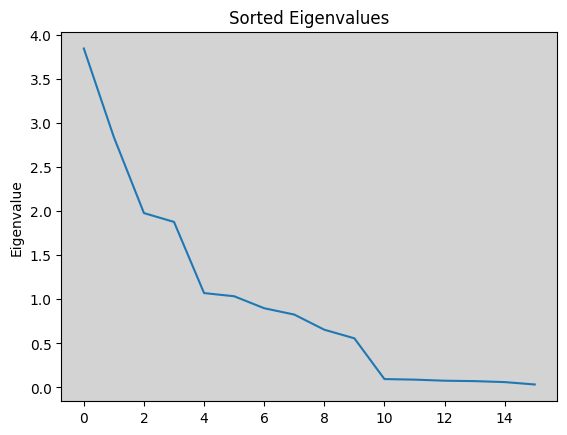

In [40]:
sorted_eigenvalues = np.sort(eigenvalues)[::-1]
plt.figure() # Create a new figure
plt.plot(sorted_eigenvalues) # Plot the sorted eigenvalues
plt.title('Sorted Eigenvalues') # Set the title of the plot
plt.ylabel('Eigenvalue') # Label the y-axis
plt.show() # Display the plot


In [41]:
df_pca


,0,1,2,3,4,5,6,7,8
0,-0.778557,-0.385804,-0.881133,-0.088437,-0.224701,-0.247468,0.362221,-0.230600,0.505227
1,2.305157,1.201617,0.981393,-1.246902,0.341739,0.218263,-0.212220,0.569581,-1.557223
2,1.556534,-0.245257,2.285892,-3.280033,-0.216542,0.185582,0.873457,0.140043,-0.048036
3,-1.953670,0.059587,-1.362906,0.647410,-0.832294,0.765495,-0.400529,-1.059087,0.190466
4,-0.334140,-1.237849,-1.194497,-1.360040,-0.189430,-0.016731,0.560911,-0.286790,0.798457
...,...,...,...,...,...,...,...,...,...
4913,-0.006289,-0.144437,0.739913,2.116832,-0.592456,0.104201,-0.239423,-0.255340,-0.755059
4914,-0.586495,0.122686,1.556426,-1.443236,-0.247104,0.405508,0.325986,0.243838,0.911632
4915,0.528737,-0.229404,0.146780,0.192494,0.192546,-0.349711,-0.078934,-0.039218,-0.829251
4916,-0.612002,-0.765746,-0.818500,0.452815,-0.053653,-0.279583,0.286087,-0.041672,0.180026


In [42]:
x_pca = df_pca.copy()

x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(x_pca, y, test_size=0.2,
                                                                    shuffle=False,
                                                                    random_state=87)

In [43]:
print('Train set:')
unique, counts = np.unique(y_train_pca, return_counts=True)
print(np.asarray((unique, counts)).T)

print('Test set:')
unique, counts = np.unique(y_test_pca, return_counts=True)
print(np.asarray((unique, counts)).T)


Train set:
[[   0 1985]
 [   1 1949]]
Test set:
[[  0 495]
 [  1 489]]


Best hyperparameters: {'learning_rate': 0.05, 'loss': 'log_loss', 'max_depth': 3, 'n_estimators': 100}
Best cross-validation score: 0.88
Training Set: Classification report
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      1985
           1       0.89      0.90      0.89      1949

    accuracy                           0.89      3934
   macro avg       0.89      0.89      0.89      3934
weighted avg       0.89      0.89      0.89      3934


Test Set: Classification report
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       495
           1       0.81      0.89      0.85       489

    accuracy                           0.84       984
   macro avg       0.84      0.84      0.84       984
weighted avg       0.84      0.84      0.84       984



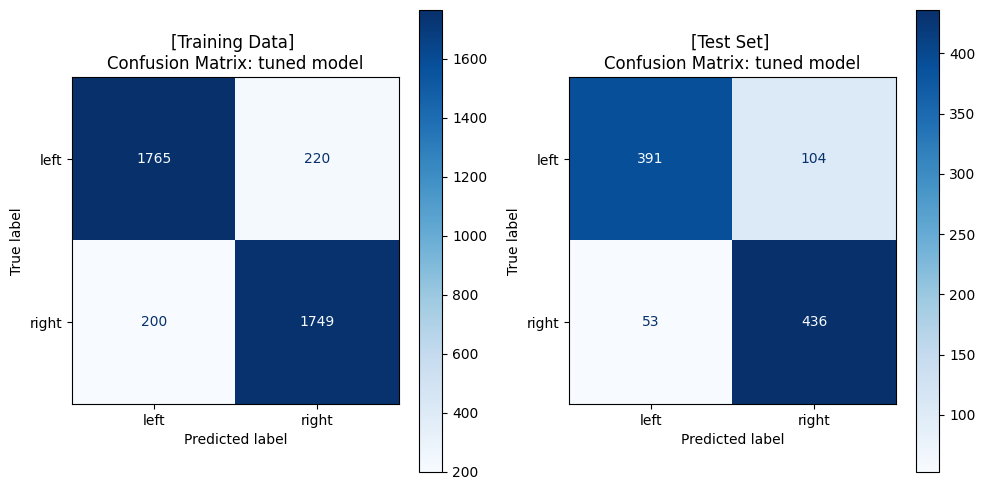

Processing time: 18.41 minutes


In [44]:
tuned_gb, accuracy_gb, cm_train_gb, cm_test_gb, processing_gb_time = tune_train_test_pipeline(base_clf, clf_params, x_train_pca, y_train_pca, x_test_pca, y_test_pca)

Try feature normalisation to see if we get better results

In [45]:
from sklearn.preprocessing import StandardScaler

x_scaler = StandardScaler().fit(x_train)

x_scale_train = x_scaler.transform(x_train)
x_scale_test  = x_scaler.transform(x_test)

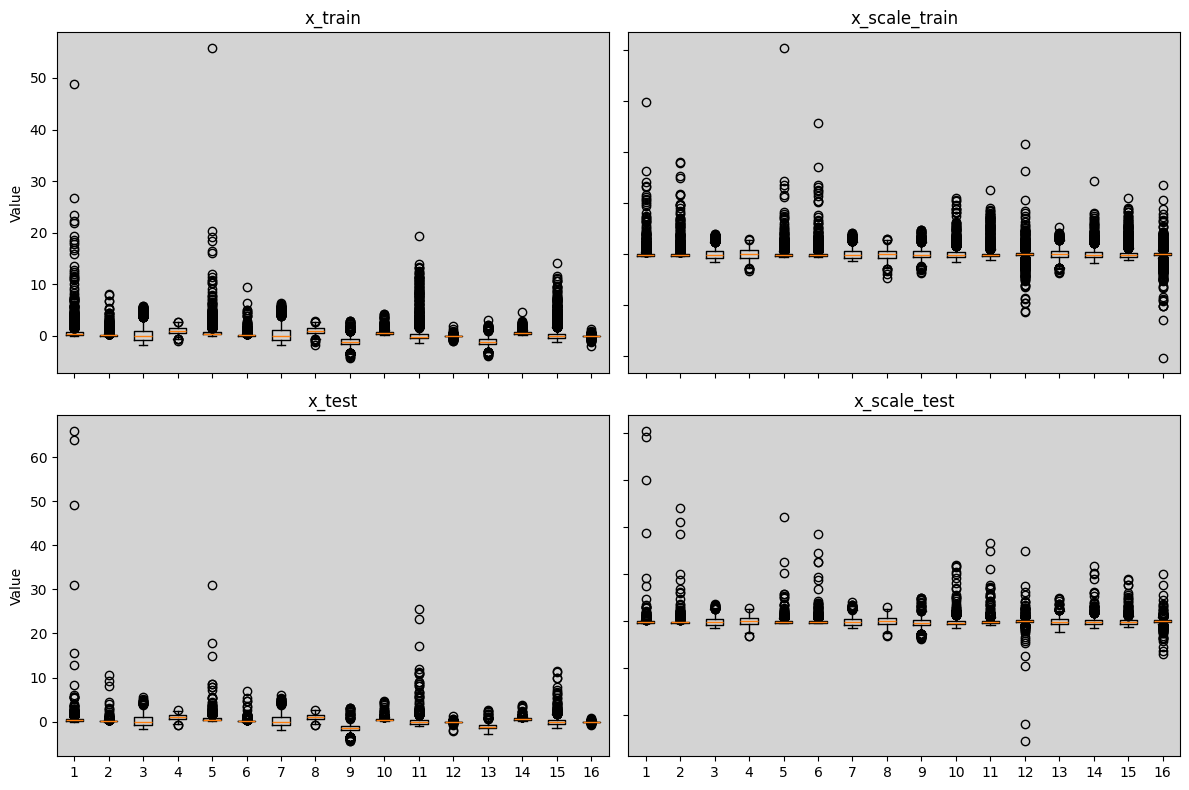

In [46]:
# Create subplots in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Compare x_train and x_scale_train
axs[0, 0].boxplot(x_train)
axs[0, 0].set_title("x_train")
axs[0, 1].boxplot(x_scale_train)
axs[0, 1].set_title("x_scale_train")

# Compare x_test and x_scale_test
axs[1, 0].boxplot(x_test)
axs[1, 0].set_title("x_test")
axs[1, 1].boxplot(x_scale_test)
axs[1, 1].set_title("x_scale_test")

# Set y-axis label
for ax in axs.flat:
    ax.set(ylabel="Value")

# Add labels to the x-axis
for ax in axs.flat:
    ax.label_outer()

# Adjust layout for better appearance
plt.tight_layout()

# Show the boxplots
plt.show()

Best hyperparameters: {'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 2, 'n_estimators': 50}
Best cross-validation score: 0.88
Training Set: Classification report
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      1985
           1       0.89      0.87      0.88      1949

    accuracy                           0.88      3934
   macro avg       0.88      0.88      0.88      3934
weighted avg       0.88      0.88      0.88      3934


Test Set: Classification report
              precision    recall  f1-score   support

           0       0.87      0.80      0.84       495
           1       0.82      0.88      0.85       489

    accuracy                           0.84       984
   macro avg       0.84      0.84      0.84       984
weighted avg       0.84      0.84      0.84       984



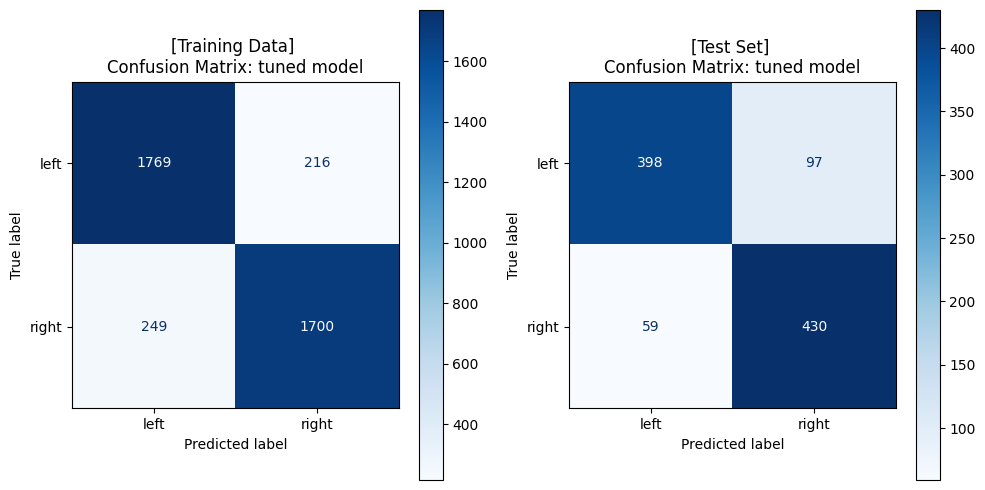

Processing time: 30.06 minutes


In [47]:
tuned_gb, accuracy_gb, cm_train_gb, cm_test_gb, processing_gb_time = tune_train_test_pipeline(base_clf, clf_params, x_scale_train, y_train, x_scale_test, y_test)

### Extract the information from the 8-channel setup, according to the Ant-Neuro headset and execute the initial comparison (no normalization or PCA)

In [24]:
### FOR TRAINING WITH 2 CLASSES (LEFT, RIGHT)

# Define your pre-made selection of channels
channel_selection = ['C4', 'F4', 'Fpz', 'Fz', 'Cz', 'Pz', 'C3', 'F3']
channel_indices = [13, 36, 23, 34, 11, 51, 9, 32]
 
# tmin, tmax = 1, 4
tmin, tmax = 0.5, 2.5

# To exclude any bad eeg data automatically from the epochs if there is any
eeg_channel_inds_set = [ mne.pick_types(
    raw_obj.info,
    meg=False,
    eeg=True,
    stim=False,
    eog=False,
    exclude='bads',
) for raw_obj in raw_obj_set
]

epoched_set = [mne.Epochs(
    raw_obj,
    events,
    dict(left=2, right=3), # Class labels we're interested in
    tmin=tmin,
    tmax=tmax,
    proj=False,
    picks=channel_indices,
    baseline=None,
    preload=True
) for raw_obj,events,eeg_channel_inds in zip(raw_obj_set, events_set, eeg_channel_inds_set)
]

Not setting metadata
45 matching events found
No baseline correction applied
Using data from preloaded Raw for 45 events and 321 original time points ...
0 bad epochs dropped
Not setting metadata
45 matching events found
No baseline correction applied
Using data from preloaded Raw for 45 events and 321 original time points ...
0 bad epochs dropped
Not setting metadata
45 matching events found
No baseline correction applied
Using data from preloaded Raw for 45 events and 321 original time points ...
0 bad epochs dropped
Not setting metadata
45 matching events found
No baseline correction applied
Using data from preloaded Raw for 45 events and 321 original time points ...
0 bad epochs dropped
Not setting metadata
45 matching events found
No baseline correction applied
Using data from preloaded Raw for 45 events and 321 original time points ...
0 bad epochs dropped
Not setting metadata
45 matching events found
No baseline correction applied
Using data from preloaded Raw for 45 events and 

In [25]:
# Convert data from Volt to milliVolt
X_set = [(epoched.get_data() * 1e3).astype(np.float32) for epoched in epoched_set]
X_ML_set = X_set.copy()
X_DL_set = X_set.copy()

# Convert class labels to 0 and 1 instead of 2 and 3
y_set = [(epoched.events[:, 2] - 2).astype(np.int64) for epoched in epoched_set]
CLASSES = ["left", "right"]
cl1 = CLASSES[0]
cl2 = CLASSES[1]

In [26]:
# Might be easier for feature extraction to put the epochs as the last dimension
X_ML_set = [np.transpose(X_ML, (1, 2, 0)) for X_ML in X_ML_set]

In [27]:
# Determine indices where y = 0 (left fist) and where y = 1 (right fist)
mask_0_set = [y==0 for y in y_set]
mask_1_set = [y==1 for y in y_set]

In [28]:
# Bandpass the signal
X_ML_set = [bandpass(X_ML, 8, 15, 160) for X_ML in X_ML_set]

In [29]:
# Call the psd function on the bandpassed epochs of the two different classes
_, freqs = psd(X_ML_set[0][:,:,mask_0_set[0]])
psds_left_set = [psd(X_ML_set[i][:,:,mask_0_set[i]])[0] for i in range(len(X_ML_set))]
psds_right_set = [psd(X_ML_set[i][:,:,mask_1_set[i]])[0] for i in range(len(X_ML_set))]
trials_PSD = {cl1: psds_left_set[0], cl2: psds_right_set[0]}

In [30]:
trials_logvar1_set = [logvar(X_ML[:,:,mask_0]) for X_ML, mask_0 in zip(X_ML_set,mask_0_set)]
trials_logvar2_set = [logvar(X_ML[:,:,mask_1]) for X_ML, mask_1 in zip(X_ML_set,mask_1_set)]
trials_logvar = {cl1: trials_logvar1_set[0],
                 cl2: trials_logvar2_set[0]}

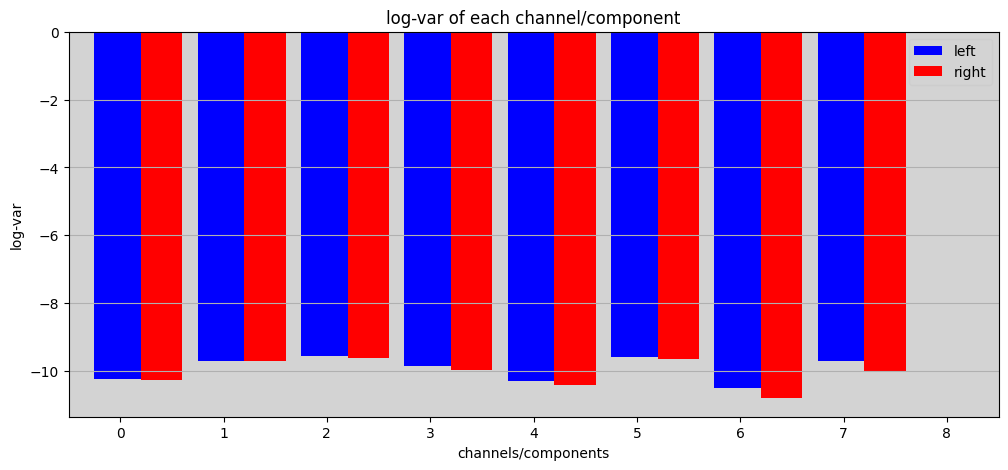

In [31]:
# Plot logvar before CSP
plot_logvar(trials_logvar)

In [32]:
# Estimation of W needs to happen on training data with annotations
# Otherwise, it's not possible
W_set = [csp(X_ML_set[i][:,:,mask_0_set[i]], X_ML_set[i][:,:,mask_1_set[i]]) for i in range(len(X_ML_set))]
X_ML_CSP_set = [apply_mix(W, X_ML) for W, X_ML in zip(W_set,X_ML_set)]

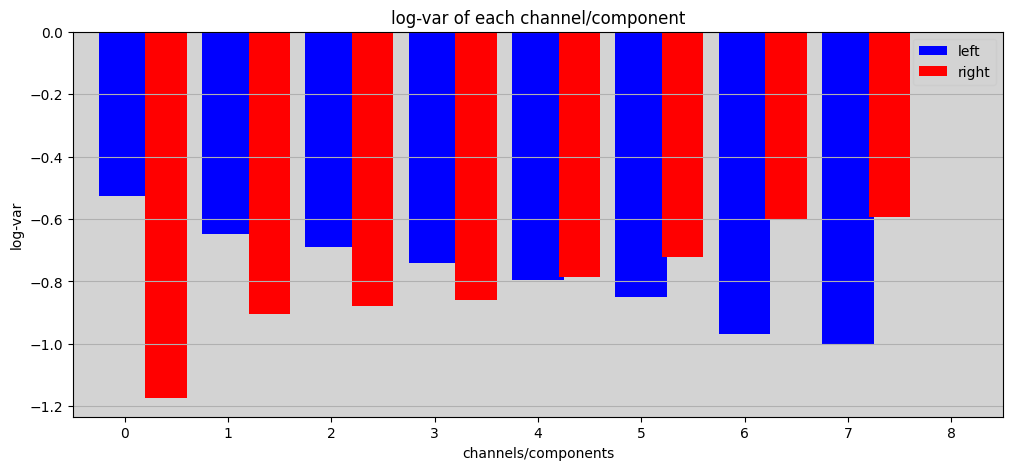

In [33]:
# Now, we visualize the average log-var of each CSP component output, repeating
# the comparison of differences between the channel log-vars of the 2 classes
trials_logvar1_set = [logvar(X_ML[:,:,mask_0]) for X_ML, mask_0 in zip(X_ML_CSP_set,mask_0_set)]
trials_logvar2_set = [logvar(X_ML[:,:,mask_1]) for X_ML, mask_1 in zip(X_ML_CSP_set,mask_1_set)]
trials_logvar = {cl1: trials_logvar1_set[0],
                 cl2: trials_logvar2_set[0]}
plot_logvar(trials_logvar)

In [34]:
# We can now also compare the class-specific mean PSD's at the output of the
# CSP component channels
_, freqs = psd(X_ML_CSP_set[0][:,:,mask_0_set[0]])
psd_left_set = [psd(X_ML_CSP_set[i][:,:,mask_0_set[i]])[0] for i in range(len(X_ML_CSP_set))]
psd_right_set = [psd(X_ML_CSP_set[i][:,:,mask_1_set[i]])[0] for i in range(len(X_ML_CSP_set))]
trials_PSD = {cl1: psd_left_set[0], cl2: psd_right_set[0]}

In [35]:
# First, we calculate the PSD of each CSP channel of each trial in X_ML_CSP
_, freqs = psd(X_ML_CSP_set[0])
X_ML_CSP_PSD_set = [psd(X_ML_CSP)[0] for X_ML_CSP in X_ML_CSP_set]

In [36]:
# Now that all CSP calculations have been made subject specific, the features and labels can be merged
ML_features_set = [extract_features(X_ML_CSP_PSD, X_ML_CSP, [0, -2]) for X_ML_CSP_PSD, X_ML_CSP in zip(X_ML_CSP_PSD_set, X_ML_CSP_set)]
ML_features = pd.concat(ML_features_set)
mask_0 = np.concatenate(mask_0_set)
mask_1 = np.concatenate(mask_1_set)
y = np.concatenate(y_set)

In [37]:
# split the data in train and test
from sklearn.model_selection import train_test_split

x = ML_features.copy()
y = y.copy()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    shuffle=False,
                                                    random_state=87)

Best hyperparameters: {'learning_rate': 0.05, 'loss': 'log_loss', 'max_depth': 2, 'n_estimators': 50}
Best cross-validation score: 0.70
Training Set: Classification report
              precision    recall  f1-score   support

           0       0.71      0.71      0.71      1985
           1       0.71      0.71      0.71      1949

    accuracy                           0.71      3934
   macro avg       0.71      0.71      0.71      3934
weighted avg       0.71      0.71      0.71      3934


Test Set: Classification report
              precision    recall  f1-score   support

           0       0.68      0.68      0.68       495
           1       0.67      0.67      0.67       489

    accuracy                           0.68       984
   macro avg       0.68      0.68      0.68       984
weighted avg       0.68      0.68      0.68       984



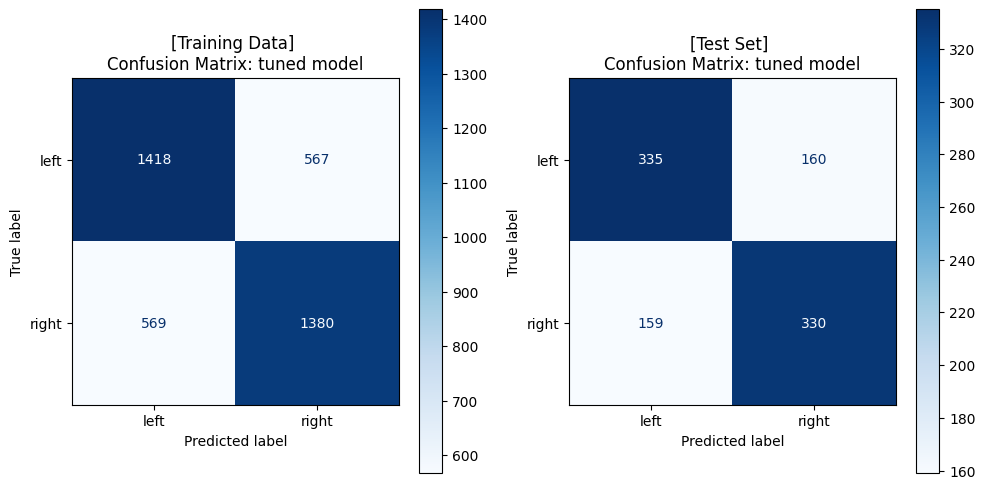

Processing time: 37.28 minutes


In [38]:
# Train the final ML model with the selected channels
base_clf = GBC()
clf_params = {
    'loss': ['log_loss', 'exponential'],  # The loss function to be optimized.
    'n_estimators': [25, 50, 100, 150, 200],  # The number of boosting stages (trees)
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5],  # The step size shrinkage used to prevent overfitting
    'max_depth': [2, 3, 4, 5]}  # Maximum depth of the individual trees
tuned_gb, accuracy_gb, cm_train_gb, cm_test_gb, processing_gb_time = tune_train_test_pipeline(base_clf, clf_params, x_train, y_train, x_test, y_test)

with open('Physionet_2_class_best.pkl', 'wb') as f:
    pickle.dump(tuned_gb, f)